# Handling Imbalanced Data in Building Energy Benchmarking
### Prepared by: Said Bolluk

This study performs building energy benchmarking over an imbalanced dataset using several machine learning models and aims to reduce the classification loss by employing a cost-sensitive approach. You can access the proceedings book from this link: https://ipcmc2022.yildiz.edu.tr/proceedings-book/

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, ComplementNB, CategoricalNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, fbeta_score
from sklearn.metrics import brier_score_loss, matthews_corrcoef, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

import requests as rq
import io
import random
import os
import timeit, time

# Set a seed number for code reproducibility
np.random.seed(42)
random.seed(42)

# Display more columns
pd.options.display.max_columns = 50

# Set a resolution for images
plt.rcParams['figure.dpi'] = 75

In [2]:
# Start counting a run time
overall_start = timeit.default_timer()

# 1) Data Preparation

In [3]:
mydf20 = pd.read_csv("2020_Building_Energy_Benchmarking.csv")

In [4]:
mydf20.head()

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,Longitude,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofFloors,NumberofBuildings,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUIWN(kBtu/sf),SourceEUI(kBtu/sf),EPAPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,Electricity(kWh),SteamUse(kBtu),NaturalGas(therms),ComplianceStatus,ComplianceIssue,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,2020,MAYFLOWER PARK HOTEL,NonResidential,0659000030,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61220,-122.33799,DOWNTOWN,1.0,1927,12,1,88434,88434,0,92.0,55.7,54.6,4923562.0,4824773.0,116.3,113.9,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,801392,1457837,6326,Compliant,No Issue,2734351.0,632586.0,169.1,1.9
1,2,2020,PARAMOUNT HOTEL,NonResidential,0659000220,724 PINE ST,SEATTLE,WA,98101.0,47.61317,-122.33393,DOWNTOWN,1.0,1996,11,1,103566,88502,15064,99.0,40.7,40.7,3601694.0,3601694.0,81.1,81.1,Hotel,Hotel,88502.0,Parking,15064.0,Restaurant,4622.0,568667,0,16614,Compliant,No Issue,1940292.0,1661402.0,98.6,1.1
2,3,2020,WESTIN HOTEL (Parent Building),NonResidential,0659000475,1900 5TH AVE,SEATTLE,WA,98101.0,47.61367,-122.33822,DOWNTOWN,1.0,1969,41,3,956110,759392,196718,98.0,44.1,44.1,36772776.0,36772776.0,101.7,101.7,Hotel,Hotel,834705.0,Parking,120545.0,Swimming Pool,0.0,7478716,10359896,8955,Compliant,No Issue,25517379.0,895500.0,1043.2,1.4
3,5,2020,HOTEL MAX,NonResidential,0659000640,620 STEWART ST,SEATTLE,WA,98101.0,47.61412,-122.33664,DOWNTOWN,1.0,1926,10,1,61320,61320,0,97.0,48.6,48.6,2982710.0,2982710.0,87.0,87.0,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,345231,917724,8871,Compliant,No Issue,1177927.0,887059.0,129.6,2.1
4,8,2020,WARWICK SEATTLE HOTEL,NonResidential,0659000970,401 LENORA ST,SEATTLE,WA,98121.0,47.61375,-122.34047,DOWNTOWN,1.0,1980,18,1,175580,113580,62000,98.0,67.8,67.8,8364978.0,8364978.0,124.5,124.5,Hotel,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,1102452,0,46034,Compliant,No Issue,3761566.0,4603411.0,264.5,2.3


Select the columns assumed helpful in predicting the building energy efficiency class

In [5]:
feature_columns = [
    "BuildingType", "Latitude", "Longitude", 
    "YearBuilt", "SiteEUI(kBtu/sf)", "PropertyGFATotal", 
    "Electricity(kWh)", "SteamUse(kBtu)", "NaturalGas(therms)", 
    "ComplianceStatus",
]

mydf = mydf20[feature_columns]

mydf.shape

(3628, 10)

Drop empty rows

In [6]:
mydf = mydf.dropna(axis=0)

mydf.shape

(3515, 10)

## Drop outliers

The range for the outliers set to be three times of std away from the mean

In [7]:
# Delete outliers for: PropertyGFATotal
upper_limit = np.ceil(mydf['PropertyGFATotal'].mean() + 3 * mydf['PropertyGFATotal'].std())
drop_rows = mydf[mydf["PropertyGFATotal"] > upper_limit].index
mydf = mydf.drop(drop_rows)

In [8]:
# Delete outliers for: PropertyGFATotal
upper_limit = np.ceil(mydf['Electricity(kWh)'].mean() + 3 * mydf['Electricity(kWh)'].std())
drop_rows = mydf[mydf["Electricity(kWh)"] > upper_limit].index
mydf = mydf.drop(drop_rows)

In [9]:
# Delete outliers for: PropertyGFATotal
upper_limit = np.ceil(mydf['SteamUse(kBtu)'].mean() + 3 * mydf['SteamUse(kBtu)'].std())
drop_rows = mydf[mydf["SteamUse(kBtu)"] > upper_limit].index
mydf = mydf.drop(drop_rows)

In [10]:
# Delete outliers for: PropertyGFATotal
upper_limit = np.ceil(mydf['NaturalGas(therms)'].mean() + 3 * mydf['NaturalGas(therms)'].std())
drop_rows = mydf[mydf["NaturalGas(therms)"] > upper_limit].index
mydf = mydf.drop(drop_rows)

In [11]:
mydf.shape

(3331, 10)

In [12]:
mydf.isnull().sum()

BuildingType          0
Latitude              0
Longitude             0
YearBuilt             0
SiteEUI(kBtu/sf)      0
PropertyGFATotal      0
Electricity(kWh)      0
SteamUse(kBtu)        0
NaturalGas(therms)    0
ComplianceStatus      0
dtype: int64

Slightly improve the imbalanced form of the target variable

In [13]:
# Display the class distribution before the transformation
compliants = mydf["ComplianceStatus"].value_counts()[0]
not_compliants = mydf["ComplianceStatus"].value_counts()[1]
print(f"Compliants: {compliants/mydf.shape[0]:.2f}")
print(f"Not Compliants: {not_compliants/mydf.shape[0]:.2f}")

Compliants: 0.97
Not Compliants: 0.03


In [14]:
# Remove 60% of the data with "compliant" status to balance the distribution
mydf_reduced = mydf.drop(mydf.loc[mydf["ComplianceStatus"]=="Compliant"].sample(frac=0.60).index)
mydf_reduced.shape

# Display the class distribution after the transformation
compliants = mydf_reduced["ComplianceStatus"].value_counts()[0]
not_compliants = mydf_reduced["ComplianceStatus"].value_counts()[1]
print(f"Compliants: {compliants/mydf_reduced.shape[0]:.2f}")
print(f"Not Compliants: {not_compliants/mydf_reduced.shape[0]:.2f}")

Compliants: 0.93
Not Compliants: 0.07


In [15]:
mydf_reduced["ComplianceStatus"].value_counts()

Compliant        1295
Not Compliant      93
Name: ComplianceStatus, dtype: int64

Save the dataset as a csv file

In [16]:
mydf_reduced.to_csv("reduced_data.csv")

Save a copy of the reduced dataset and proceed with it

In [17]:
data = mydf_reduced.copy()

Define the feaures (X) and target (y)

In [18]:
# Features
X = data.drop(columns=["ComplianceStatus"])
# Apply encoding for the categorical variables
X = pd.get_dummies(X)

# Target
# Transform the entries of the target varible: string >>> integer
compliance_mapping = {"Compliant": 1, "Not Compliant": 0}
data["ComplianceStatus"] = data["ComplianceStatus"].map(compliance_mapping)
y = data["ComplianceStatus"]

print("Size of feature set:", X.shape)
print("Size of target:", y.shape)

Size of feature set: (1388, 16)
Size of target: (1388,)


Split data into training and test sets. Here, the aim is to assess and improve the generalization power of a machine learning model so that we can utilize the model over not only the sample but also the population. Therefore, the model should be trained using the training set and its generalization power should be examined over the test set.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
scaler = StandardScaler()  
# Only fit training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# Apply same transformation to test data
X_test = scaler.transform(X_test)

Collect the results of each classification models in the **report_df**

In [21]:
report_df = pd.DataFrame()

# 2) Building Classification Models

## 2.a) Classical Models

### Support Vector Machine (SVM)

In [22]:
# Initiate the model
svc = SVC(probability=True, class_weight="balanced", random_state=42)

# Creating a gridsearch model to detect to optimal parameters:

grid_params = {"C": [0.01, 0.05, 0.1, 0.5, 1.0], "kernel": ['linear', 'poly', 'rbf', 'sigmoid'], 
               "degree": [2, 3, 4, 5, 6, 7, 8], "gamma": ["scale", "auto"]}

start = timeit.default_timer()

grid_search = GridSearchCV(svc, grid_params, verbose=1, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

stop = timeit.default_timer()
svc_time = stop - start

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


In [23]:
# According to the results of GridSearch, the best estimation parameters are and the score are:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

SVC(C=0.01, class_weight='balanced', degree=2, probability=True,
    random_state=42)
0.7576186970923813


In [24]:
# Run the model with the optimal settings displayed above:

start = timeit.default_timer()

svc = SVC(C=0.01, degree=2, probability=True, random_state=42)

svc.fit(X_train, y_train)

stop = timeit.default_timer()
svc_time = stop - start

In [25]:
svc_results = {"Classifier": "Support Vector Machine", 
               "Time (seconds)": "{:e}".format(svc_time), 
               "Accuracy": accuracy_score(y_test, svc.predict(X_test)), 
               "Balanced Accuracy": balanced_accuracy_score(y_test, svc.predict(X_test)),
               "Precision": precision_score(y_test, svc.predict(X_test)),
               "Recall": recall_score(y_test, svc.predict(X_test)),
               "ROC-AUC Score ": roc_auc_score(y_test, svc.predict(X_test)),
               "F1-Score": f1_score(y_test, svc.predict(X_test)), 
               "Brier Score": brier_score_loss(y_test, svc.predict_proba(X_test)[:, 0]),
              }
              
report_df = report_df.append(svc_results, ignore_index=True, sort=True)

### Gaussian Naive Bayes

In [26]:
# Split data into train (training + validation) and test sets once more for the Naive Bayes models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
# Use MinMaxScaler to perform Bayes estimation
# since some models cannot work with negative values
scaler = MinMaxScaler()  
# Only fit training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# Apply same transformation to test data
X_test = scaler.transform(X_test)

In [28]:
# Initiate the model
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)
gaussian_f1 = f1_score(y_test, gaussian_nb.predict(X_test))
gaussian_brier = brier_score_loss(y_test, gaussian_nb.predict(X_test))
print(f"F1-Score for gaussian_nb: {gaussian_f1:.3f}")
print(f"Brier Score for gaussian_nb: {gaussian_brier:.3f}")

complement_nb = ComplementNB()
complement_nb.fit(X_train, y_train)
complement_f1 = f1_score(y_test, complement_nb.predict(X_test))
complement_brier = brier_score_loss(y_test, complement_nb.predict(X_test))
print(f"F1-Score for complement_nb: {complement_f1:.3f}")
print(f"Brier Score for complement_nb: {complement_brier:.3f}")

multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)
multi_f1 = f1_score(y_test, multi_nb.predict(X_test))
multi_brier = brier_score_loss(y_test, multi_nb.predict(X_test))
print(f"F1-Score for multinomial_nb: {multi_f1:.3f}")
print(f"Brier Score for multinomial_nb: {multi_brier:.3f}")

F1-Score for gaussian_nb: 0.136
Brier Score for gaussian_nb: 0.882
F1-Score for complement_nb: 0.557
Brier Score for complement_nb: 0.591
F1-Score for multinomial_nb: 0.975
Brier Score for multinomial_nb: 0.049


In [29]:
# Multinomial Naive Bayes Classifier is selected for the rest of the study
# according to the above results

start = timeit.default_timer()

multi_nb = ComplementNB()
multi_nb.fit(X_train, y_train)

stop = timeit.default_timer()
nb_time = stop - start

In [30]:
nb_results = {
    "Classifier": "Multinomial Naive Bayes", 
    "Time (seconds)": "{:e}".format(nb_time), 
    "Accuracy": accuracy_score(y_test, multi_nb.predict(X_test)), 
    "Balanced Accuracy": balanced_accuracy_score(y_test, multi_nb.predict(X_test)),
    "Precision": precision_score(y_test, multi_nb.predict(X_test)),
    "Recall": recall_score(y_test, multi_nb.predict(X_test)),
    "ROC-AUC Score ": roc_auc_score(y_test, multi_nb.predict(X_test)),
    "F1-Score": f1_score(y_test, multi_nb.predict(X_test)), 
    "Brier Score": brier_score_loss(y_test, multi_nb.predict_proba(X_test)[:, 0]),
}

report_df = report_df.append(nb_results, ignore_index=True, sort=True)

Before moving with the other classifiers, lets use StandardScaler once more for the rest of the study

In [31]:
# Split data into train (training + validation) and test sets:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()  
# Only fit training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# Apply same transformation to test data
X_test = scaler.transform(X_test)

### Logistic Regression (Logistic Discrimination)

In [32]:
# Initiate the model
logi = LogisticRegression(random_state=42)

c_list = [0.01, 0.05, 0.1, 0.5, 1.0]

solver_list = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]

weight_dict = {1: 1, 0: 3}
weights = [None, "balanced", weight_dict]

grid_params = {"C": c_list, "solver": solver_list, "class_weight": weights}

grid_search = GridSearchCV(logi, grid_params, verbose=1, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0],
                         'class_weight': [None, 'balanced', {0: 3, 1: 1}],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=1)

In [33]:
#According to the results of GridSearch, the best estimation parameters are and the score are:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

LogisticRegression(C=0.01, random_state=42, solver='newton-cg')
0.9269966875230032


In [34]:
# Run the model with the optimal settings displayed above:

start = timeit.default_timer()

logi = LogisticRegression(C=0.01, solver="newton-cg", random_state=42)

logi.fit(X_train, y_train)

stop = timeit.default_timer()
logi_time = stop - start

In [35]:
logi_results = {
    "Classifier": "Logistic Regression", 
    "Time (seconds)": "{:e}".format(logi_time), 
    "Accuracy": accuracy_score(y_test, logi.predict(X_test)), 
    "Balanced Accuracy": balanced_accuracy_score(y_test, logi.predict(X_test)),
    "Precision": precision_score(y_test, logi.predict(X_test)),
    "Recall": recall_score(y_test, logi.predict(X_test)),
    "ROC-AUC Score ": roc_auc_score(y_test, logi.predict(X_test)),
    "F1-Score": f1_score(y_test, logi.predict(X_test)), 
    "Brier Score": brier_score_loss(y_test, logi.predict_proba(X_test)[:, 0]),
}
              
report_df = report_df.append(logi_results, ignore_index=True, sort=True)

### K-Nearest Neighbors

In [36]:
# Initiate the model
neighbor = KNeighborsClassifier()

grid_params = {"n_neighbors": list(range(3, 20)), "weights": ["uniform","distance"], 
               "metric": ["euclidean","manhattan", "minkowski"]}

grid_search = GridSearchCV(neighbor, grid_params, verbose=1, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 102 candidates, totalling 510 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [37]:
# According to the results of GridSearch, the best estimation parameters are and the score are:

print(grid_search.best_estimator_)
print(grid_search.best_score_)

KNeighborsClassifier(metric='euclidean', n_neighbors=9)
0.9269966875230032


In [38]:
# Test the model according to the above settings:

start = timeit.default_timer()

neighbor = KNeighborsClassifier(n_neighbors=9, metric="euclidean", weights="uniform")

neighbor.fit(X_train, y_train)

stop = timeit.default_timer()
neighbor_time = stop - start

In [39]:
neighbor_results = {
    "Classifier": "K-Nearest Neighbors", 
    "Time (seconds)": "{:e}".format(neighbor_time), 
    "Accuracy": accuracy_score(y_test, neighbor.predict(X_test)), 
    "Balanced Accuracy": balanced_accuracy_score(y_test, neighbor.predict(X_test)),
    "Precision": precision_score(y_test, neighbor.predict(X_test)),
    "Recall": recall_score(y_test, neighbor.predict(X_test)),
    "ROC-AUC Score ": roc_auc_score(y_test, neighbor.predict(X_test)),
    "F1-Score": f1_score(y_test, neighbor.predict(X_test)), 
    "Brier Score": brier_score_loss(y_test, neighbor.predict_proba(X_test)[:, 0]),
}
              
report_df = report_df.append(neighbor_results, ignore_index=True, sort=True)

### Decision Tree Classifier

In [40]:
# Initiate the model
tree = DecisionTreeClassifier(random_state=42)

criterions = ["gini", "entropy"]

splitters = ["best", "random"]

weight_dict = {1: 1, 0: 3}

class_weights = [None, "balanced", weight_dict]

grid_params = {"criterion": criterions, 
               "splitter": splitters, 
               "class_weight": class_weights}

grid_search = GridSearchCV(tree, grid_params, verbose=1, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced', {0: 3, 1: 1}],
                         'criterion': ['gini', 'entropy'],
                         'splitter': ['best', 'random']},
             verbose=1)

In [41]:
# According to the results of GridSearch, the best estimation parameters are and the score are:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=42)
0.8799365108575635


In [42]:
# Test the model according to the above settings:

start = timeit.default_timer()

tree = DecisionTreeClassifier(class_weight="balanced", criterion="entropy", random_state=42)

tree.fit(X_train, y_train)

stop = timeit.default_timer()
tree_time = stop - start

In [43]:
tree_results = {
    "Classifier": "Decision Tree", 
    "Time (seconds)": "{:e}".format(tree_time), 
    "Accuracy": accuracy_score(y_test, tree.predict(X_test)), 
    "Balanced Accuracy": balanced_accuracy_score(y_test, tree.predict(X_test)),
    "Precision": precision_score(y_test, tree.predict(X_test)),
    "Recall": recall_score(y_test, tree.predict(X_test)),
    "ROC-AUC Score ": roc_auc_score(y_test, tree.predict(X_test)),
    "F1-Score": f1_score(y_test, tree.predict(X_test)), 
    "Brier Score": brier_score_loss(y_test, tree.predict_proba(X_test)[:, 0]),
}      

report_df = report_df.append(tree_results, ignore_index=True, sort=True)

### Random Forest Classifier

In [44]:
# Initiate the model
forest = RandomForestClassifier(random_state=42)

weight_dict = {1: 1, 0: 3}

class_weights = [None, "balanced", "balanced_subsample", weight_dict]

grid_params = {"n_estimators": list(range(10,101)), 
               "criterion": ["gini", "entropy"], 
               "class_weight": class_weights}

grid_search = GridSearchCV(forest, grid_params, verbose=1, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 728 candidates, totalling 3640 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample', {0: 3, 1: 1}],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                          19, 20, 21, 22, 23, 24, 25, 26, 27,
                                          28, 29, 30, 31, 32, 33, 34, 35, 36,
                                          37, 38, 39, ...]},
             verbose=1)

In [45]:
# According to the results of GridSearch, the best estimation parameters are and the score are:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

RandomForestClassifier(n_estimators=31, random_state=42)
0.9269966875230032


In [46]:
# Set the model according to the optimal setting and calculate the run-time:

start = timeit.default_timer()

forest = RandomForestClassifier(criterion='gini', n_estimators=31, random_state=42)

forest.fit(X_train, y_train)

stop = timeit.default_timer()
forest_time = stop - start

In [47]:
forest_results = {
    "Classifier": "Random Forest", 
    "Time (seconds)": "{:e}".format(forest_time), 
    "Accuracy": accuracy_score(y_test, forest.predict(X_test)), 
    "Balanced Accuracy": balanced_accuracy_score(y_test, forest.predict(X_test)),
    "Precision": precision_score(y_test, forest.predict(X_test)),
    "Recall": recall_score(y_test, forest.predict(X_test)),
    "ROC-AUC Score ": roc_auc_score(y_test, forest.predict(X_test)),
    "F1-Score": f1_score(y_test, forest.predict(X_test)), 
    "Brier Score": brier_score_loss(y_test, forest.predict_proba(X_test)[:, 0]),
}
              
report_df = report_df.append(forest_results, ignore_index=True, sort=True)

### Classification Evaluation for Classical Models

Actual number of *Compliant* in test set: 330
Actual number of *Not Compliant* in test set: 17


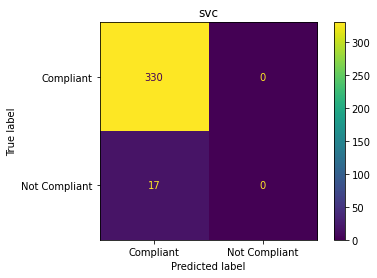

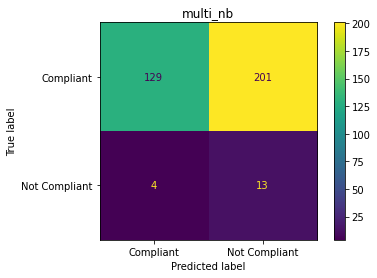

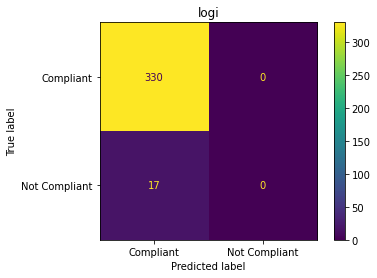

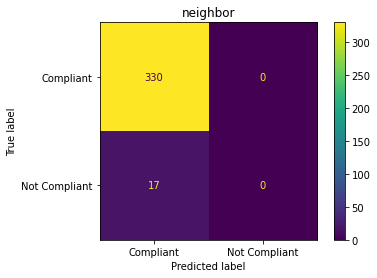

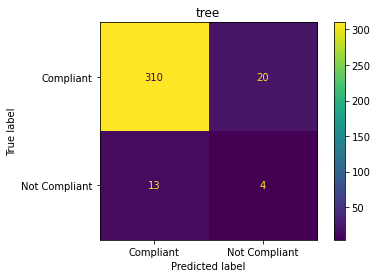

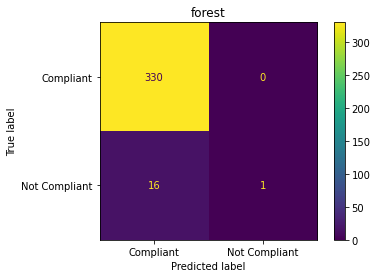

In [48]:
compliance_labels = ["Compliant", "Not Compliant"]
models = ["svc", "multi_nb", "logi", "neighbor", "tree", "forest"]

print("Actual number of *Compliant* in test set:", y_test.value_counts()[1])
print("Actual number of *Not Compliant* in test set:", y_test.value_counts()[0])

for predictor in models:
    cm = confusion_matrix(y_test, eval(predictor).predict(X_test), labels=[1,0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=compliance_labels)
    disp.plot()
    plt.title(predictor)
    plt.show()

Confusion matrices indicates that most of the models predicted the labels as COMPLIANT (1) where the actual label was NOT COMPLIANT (0). This is not surprising since we had an imbalanced set. Only model making a few actual prediction was the Decision Tree model. It made four safe estimates for the minority class. This is more obvious if we compare the results based on the Brier Score but not on the F1-Score.

Next, we will analyze ANN in making actual predictions for imbalanced datasets. We hope to get improved results with introducing cost-sensitive lost functions to the network.

## 2.b) Multilayer Perceptron (MLP)

We will use another machine learning library named Pytorch to create the MLP models. 

Import necessary libraries

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [50]:
# Recreate the data and apply transformation

# Split data into train (training + validation) and test sets:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()  
# Only fit training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# Apply same transformation to test data
X_test = scaler.transform(X_test)

### Initialization

In [51]:
# Define a neural network with Default Initialization
# Activation: sigmoid

class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.sigmoid(linear_transform(x))
            else:
                x = torch.sigmoid(linear_transform(x))
        return x

In [52]:
# Define a neural network with Xavier Initialization
# Activation: sigmoid

class Net_Xavier(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_Xavier, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.xavier_uniform_(linear.weight)
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.sigmoid(linear_transform(x))
            else:
                x = torch.sigmoid(linear_transform(x))
        return x

In [53]:
# Define a neural network with Xavier Initialization
# Activation: tanh > sigmoid

class Net_Xavier_tanh(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_Xavier_tanh, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.xavier_uniform_(linear.weight)
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.tanh(linear_transform(x))
            else:
                x = torch.sigmoid(linear_transform(x))
        return x

In [54]:
# Define a neural network with He Initialization
# Activation: relu > sigmoid

class Net_He(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_He, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.kaiming_uniform_(linear.weight, nonlinearity='relu')
            self.hidden.append(linear)

    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.relu(linear_transform(x))
            else:
                x = torch.sigmoid(linear_transform(x))
        return x

In [55]:
# Define a neural network with Uniform Initialization
# Activation: relu > sigmoid

class Net_Uniform(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_Uniform, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size,output_size)
            linear.weight.data.uniform_(0, 1)
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.relu(linear_transform(x))
            else:
                x = torch.sigmoid(linear_transform(x))
        return x

### Loss Functions

In [56]:
# Set some parameters according to the class distributions
ones = y.value_counts()[1]
zeros = y.value_counts()[0]
data_shape = X.shape[0]

zero_ratio = zeros / data_shape
one_ratio = ones / data_shape

print(f"One ratio: {one_ratio:.3f}")
print(f"Zero ratio: {zero_ratio:.3f}")

One ratio: 0.933
Zero ratio: 0.067


In [57]:
# 1) Normal Cross-Entropy

class CriterionCross(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super(CriterionCross, self).__init__(weight, reduction=reduction)
        self.weight = weight

    def forward(self, inputs, targets):

        ce_loss = F.cross_entropy(
            inputs, 
            targets, 
            reduction=self.reduction, 
            weight=self.weight
        )
        return ce_loss

In [58]:
# 2) Cost-Sensitive Cross-Entropy

class CostSensitive(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super(CostSensitive, self).__init__(weight, reduction=reduction)
        self.weight = weight

    def forward(self, inputs, targets):

        ce_loss = F.cross_entropy(
            inputs, 
            targets, 
            reduction=self.reduction, 
            weight=self.weight
        )
        if targets == 1:
            sensitive_loss = ce_loss * torch.tensor(1 + zero_ratio)
        else:
            sensitive_loss = ce_loss * torch.tensor(1 - one_ratio)
        return sensitive_loss

In [59]:
# 3) Cost-Sensitive Cross-Entropy With Exponential Term

class CostSensitiveExp(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super(CostSensitiveExp, self).__init__(weight, reduction=reduction)
        self.weight = weight

    def forward(self, inputs, targets):

        ce_loss = F.cross_entropy(
            inputs, 
            targets, 
            reduction=self.reduction, 
            weight=self.weight
        )
                
        if targets == 1:
            sensitive_loss = (ce_loss ** torch.tensor(1 + zero_ratio)).mean()
        else:
            sensitive_loss = (ce_loss ** torch.tensor(1 - one_ratio)).mean()
        return sensitive_loss

In [60]:
# 4) Focal Loss

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [61]:
# 5) Weighted Focal loss

class WeightedFocal(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(WeightedFocal, self).__init__(weight, reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, inputs, targets):

        ce_loss = F.cross_entropy(
            inputs, 
            targets, 
            reduction=self.reduction, 
            weight=self.weight
        )
        pt = torch.exp(-ce_loss)
        if targets == 1:
            focal_loss = ((1 - pt) ** torch.tensor(1 + zero_ratio) * ce_loss).mean()
        else:
            focal_loss = ((1 - pt) ** torch.tensor(1 - one_ratio) * ce_loss).mean()
            
        return focal_loss

### Training Pipeline

In [62]:
batch_size = 1

# Training Set
X_train_batch = torch.from_numpy(X_train).float()
y_train_batch = torch.from_numpy(y_train.values).float()
train_ds = torch.utils.data.TensorDataset(X_train_batch, y_train_batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True)

# Test Set
X_test_batch = torch.from_numpy(X_test).float()
y_test_batch = torch.from_numpy(y_test.values).float()
test_ds = torch.utils.data.TensorDataset(X_test_batch, y_test_batch)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=True)

Define a function that performs the MLP Classification: **train_mlp**

In [63]:
def train_mlp(
    epochs=50, 
    learning_rate=5e-3,
    loss_function="normal",
    init="xavier",
    momentum=0.7,
):
    start = timeit.default_timer()
    
    # Set the size of the neural network
    input_size = 16
    output_size = 2
    hidden_size = 9
    layers = [input_size, hidden_size, output_size]
    
    # Set a random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)

    # Initialize the model    
    if init == "normal":
        model = Net(layers)
        
    if init == "xavier":
        model = Net_Xavier(layers)
    
    if init == "xavier_tanh":
        model = Net_Xavier_tanh(layers)
        
    if init == "he_relu":
        model = Net_He(layers)
        
    if init == "uniform_relu":
        model = Net_Uniform(layers)      
        
    # Determine an optimizer
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=learning_rate,
        momentum=momentum,
    )
    
    # Select a loss function
    if loss_function == "normal":
        #criterion = CriterionCross()
        criterion = nn.CrossEntropyLoss()
    
    if loss_function == "normal_weighted":
        
        from sklearn.utils.class_weight import compute_class_weight
        class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y),
        y=y,
        )
                
        class_weights = torch.tensor(class_weights, dtype=torch.float)
        criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
        
    if loss_function == "cost_sensitive":
        criterion = CostSensitive()
        
    if loss_function == "cost_sensitive_exp":
        criterion = CostSensitiveExp()
    
    if loss_function == "focal_loss":
        criterion = FocalLoss()
    
    if loss_function == "focal_weighted":
        criterion = WeightedFocal()

    training_loss = list()
    validation_loss = list()
    validation_accuracy = list()
    
    for t in range(epochs):

        running_loss = 0
        tested_loss = 0

        for x_tr, y_tr in train_dl:
            
            y_tr = y_tr.type(torch.LongTensor)
            z = model(x_tr)            
            loss = criterion(z, y_tr)
            # Backward pass and optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()  

        epoch_loss = running_loss / X_train.shape[0]
        training_loss.append(epoch_loss)

        correct_test = 0
        for x_val, y_val in test_dl:
            
            y_val = y_val.type(torch.LongTensor)
            prediction = model(x_val)
            loss_val = criterion(prediction, y_val)
            tested_loss += loss.item()
            labels = torch.argmax(prediction, dim=1)
            correct_test += torch.sum(labels == y_val).item()

        accuracy_test = 100 * (correct_test / X_test.shape[0])
        validation_accuracy.append(accuracy_test)
        test_loss_epoch = tested_loss / X_test.shape[0]
        validation_loss.append(test_loss_epoch)

        #print(f"EPOCH {t+1} // Loss: {epoch_loss:.4f} & Accuracy: %{accuracy_test:.4f}")
        
    # Calculate the run time
    stop = timeit.default_timer()
    mlp_time = stop - start
    
    # Visualize the results
    import matplotlib.ticker as ticker
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # ax1: Loss vs. Epoch
    ax1.plot(np.arange(1, epochs+1, step=1), training_loss, label="training")
    ax1.plot(np.arange(1, epochs+1, step=1), validation_loss, label="test")
    ax1.legend()
    ax1.set_xlabel("Epoch") 
    ax1.set_ylabel("Log-loss")    
    ax1.set_title("Validation Curve")
    # ax2: Accuracy vs. Epoch
    ax2.plot(np.arange(1, epochs+1, step=1), validation_accuracy)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Test Accuracy")
    ax2.set_title("Accuracy Curve")
    # Display figures
    # set the spacing between subplots
    plt.subplots_adjust(
        left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.88, 
        wspace=0.2, 
        hspace=0.4,
    )
    plt.suptitle(
        f"MLP with {loss_function} loss: [epoch={epochs} & lr={learning_rate} & momentum={momentum}]", 
        fontsize=12
    )
    plt.show()
    
    # Classification evaluation metrics
    feed_forward = model(torch.tensor(X_test).float())
    predicted_labels = torch.argmax(feed_forward, dim=1).detach().numpy()
    ## Metrics
    mlp_accuracy = accuracy_score(y_test, predicted_labels)
    mlp_balanced_accuracy = balanced_accuracy_score(y_test, predicted_labels)
    mlp_precision = precision_score(y_test, predicted_labels)
    mlp_recall = recall_score(y_test, predicted_labels)
    mlp_roc = roc_auc_score(y_test, predicted_labels)
    mlp_f1 = f1_score(y_test, predicted_labels)
    mlp_brier = brier_score_loss(y_test, predicted_labels)
    ## Dataframe to display results
    mlp_results = {
        "Classifier": f"MLP with {loss_function} loss", 
        "Time (seconds)": "{:e}".format(mlp_time), 
        "Accuracy": mlp_accuracy, 
        "Balanced Accuracy": mlp_balanced_accuracy,
        "Precision": mlp_precision,
        "Recall": mlp_recall,
        "F1-Score": mlp_f1, 
        "Brier Score": mlp_brier,
    }
    print(f"The classification results for MLP with {loss_function} loss: {mlp_results}")
    
    # Draw confusion matrix
    plt.figure(figsize=(10, 10))
    compliance_labels = ["Compliant", "Not Compliant"]
    cm = confusion_matrix(y_test, predicted_labels, labels=[1,0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=compliance_labels)
    disp.plot()
    plt.title(f"MLP with {loss_function} loss function")
    plt.show()
    
    return feed_forward, mlp_results
    
    # END

### Test MLP Models

1) Normal Loss

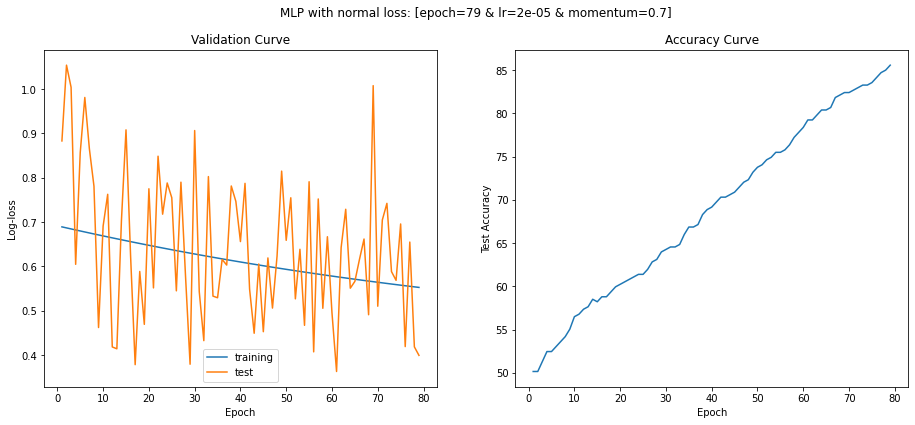

The classification results for MLP with normal loss: {'Classifier': 'MLP with normal loss', 'Time (seconds)': '7.301194e+01', 'Accuracy': 0.8559077809798271, 'Balanced Accuracy': 0.5336898395721925, 'Precision': 0.9545454545454546, 'Recall': 0.8909090909090909, 'F1-Score': 0.9216300940438871, 'Brier Score': 0.1440922190201729}


<Figure size 720x720 with 0 Axes>

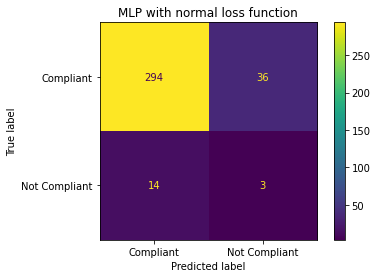

In [64]:
feed, result_dict = train_mlp(
    epochs=79, 
    learning_rate=2e-5,
    loss_function="normal",
    init="xavier_tanh",
    momentum=0.7,
)

# Save the results
report_df = report_df.append(result_dict, ignore_index=True, sort=True)

2) Cost-Sensitive Loss

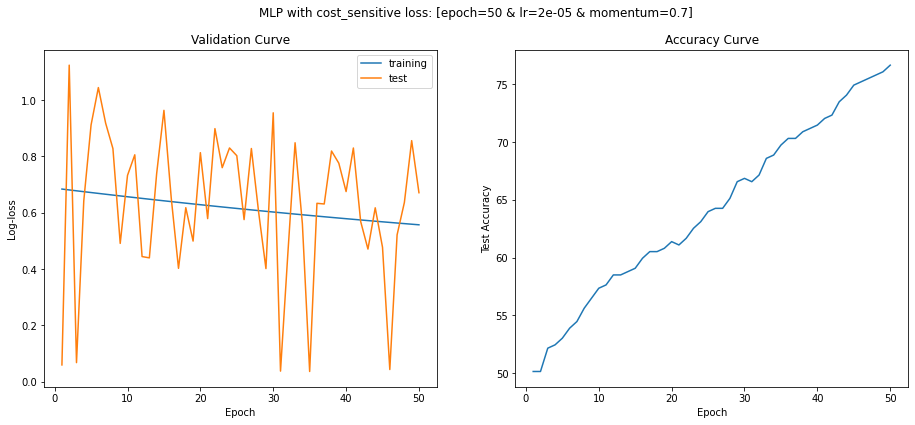

The classification results for MLP with cost_sensitive loss: {'Classifier': 'MLP with cost_sensitive loss', 'Time (seconds)': '5.236140e+01', 'Accuracy': 0.7665706051873199, 'Balanced Accuracy': 0.4867201426024956, 'Precision': 0.9494584837545126, 'Recall': 0.796969696969697, 'F1-Score': 0.8665568369028006, 'Brier Score': 0.2334293948126801}


<Figure size 720x720 with 0 Axes>

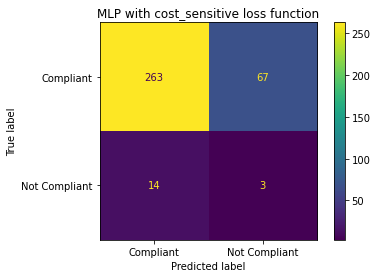

In [65]:
feed, result_dict = train_mlp(
    epochs=50, 
    learning_rate=2e-5,
    loss_function="cost_sensitive",
    init="xavier_tanh",
    momentum=0.7,
)

# Save the results
report_df = report_df.append(result_dict, ignore_index=True, sort=True)

3) Cost-Sensitive Exponential Loss

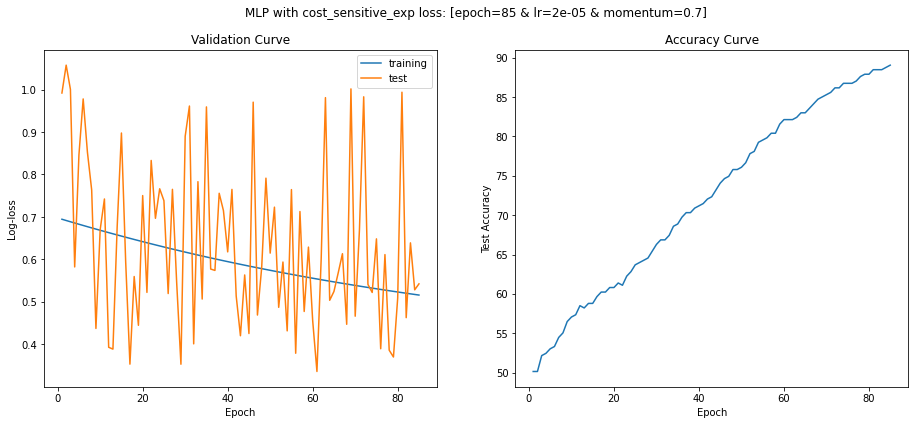

The classification results for MLP with cost_sensitive_exp loss: {'Classifier': 'MLP with cost_sensitive_exp loss', 'Time (seconds)': '1.012552e+02', 'Accuracy': 0.8904899135446686, 'Balanced Accuracy': 0.5518716577540107, 'Precision': 0.95625, 'Recall': 0.9272727272727272, 'F1-Score': 0.9415384615384615, 'Brier Score': 0.10951008645533142}


<Figure size 720x720 with 0 Axes>

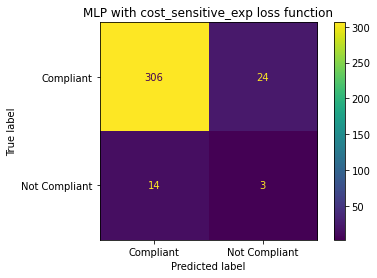

In [66]:
feed, result_dict = train_mlp(
    epochs=85, 
    learning_rate=2e-5,
    loss_function="cost_sensitive_exp",
    init="xavier_tanh",
    momentum=0.7,
)

# Save the results
report_df = report_df.append(result_dict, ignore_index=True, sort=True)

4) Focal Loss

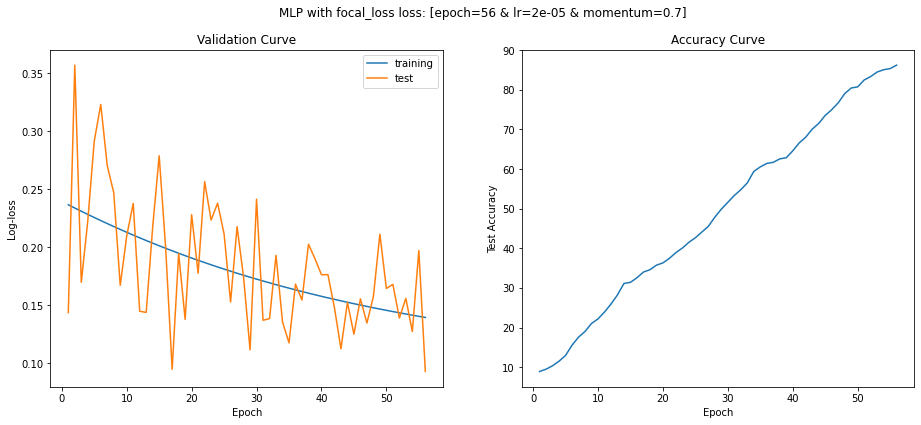

The classification results for MLP with focal_loss loss: {'Classifier': 'MLP with focal_loss loss', 'Time (seconds)': '7.681656e+01', 'Accuracy': 0.861671469740634, 'Balanced Accuracy': 0.5367201426024956, 'Precision': 0.9548387096774194, 'Recall': 0.896969696969697, 'F1-Score': 0.9249999999999999, 'Brier Score': 0.138328530259366}


<Figure size 720x720 with 0 Axes>

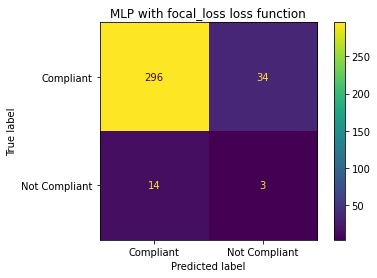

In [67]:
feed, result_dict = train_mlp(
    epochs=56, 
    learning_rate=2e-5,
    loss_function="focal_loss",
    init="xavier",
    momentum=0.7,
)

# Save the results
report_df = report_df.append(result_dict, ignore_index=True, sort=True)

5) Weighted Focal Loss

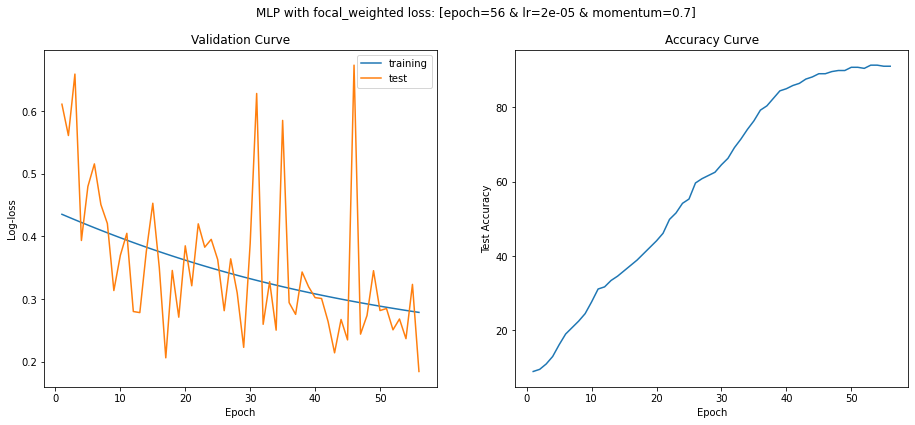

The classification results for MLP with focal_weighted loss: {'Classifier': 'MLP with focal_weighted loss', 'Time (seconds)': '8.746767e+01', 'Accuracy': 0.9106628242074928, 'Balanced Accuracy': 0.5066844919786097, 'Precision': 0.9516616314199395, 'Recall': 0.9545454545454546, 'F1-Score': 0.9531013615733737, 'Brier Score': 0.0893371757925072}


<Figure size 720x720 with 0 Axes>

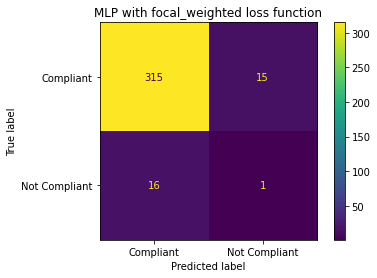

In [68]:
feed, result_dict = train_mlp(
    epochs=56, 
    learning_rate=2e-5,
    loss_function="focal_weighted",
    init="xavier",
    momentum=0.7,
)

# Save the results
report_df = report_df.append(result_dict, ignore_index=True, sort=True)

# RESULTS

In [69]:
report_df = report_df[["Classifier", "Accuracy", 
                       "Balanced Accuracy", "Precision", "Recall", 
                       "F1-Score", "Brier Score"]]

report_df = report_df.sort_values("Brier Score", ascending=True)
report_df.round(3)

,Classifier,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,Brier Score
10,MLP with focal_weighted loss,0.911,0.507,0.952,0.955,0.953,0.089
8,MLP with cost_sensitive_exp loss,0.890,0.552,0.956,0.927,0.942,0.110
9,MLP with focal_loss loss,0.862,0.537,0.955,0.897,0.925,0.138
6,MLP with normal loss,0.856,0.534,0.955,0.891,0.922,0.144
7,MLP with cost_sensitive loss,0.767,0.487,0.949,0.797,0.867,0.233
1,Multinomial Naive Bayes,0.409,0.578,0.970,0.391,0.557,0.283
0,Support Vector Machine,0.951,0.500,0.951,1.000,0.975,0.818
2,Logistic Regression,0.951,0.500,0.951,1.000,0.975,0.818
5,Random Forest,0.954,0.529,0.954,1.000,0.976,0.827
3,K-Nearest Neighbors,0.951,0.500,0.951,1.000,0.975,0.830


In [70]:
report_df.to_csv("results.csv")

In [71]:
report_df.sort_values("Balanced Accuracy", ascending=False).round(3)

,Classifier,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,Brier Score
4,Decision Tree,0.905,0.587,0.960,0.939,0.949,0.905
1,Multinomial Naive Bayes,0.409,0.578,0.970,0.391,0.557,0.283
8,MLP with cost_sensitive_exp loss,0.890,0.552,0.956,0.927,0.942,0.110
9,MLP with focal_loss loss,0.862,0.537,0.955,0.897,0.925,0.138
6,MLP with normal loss,0.856,0.534,0.955,0.891,0.922,0.144
5,Random Forest,0.954,0.529,0.954,1.000,0.976,0.827
10,MLP with focal_weighted loss,0.911,0.507,0.952,0.955,0.953,0.089
0,Support Vector Machine,0.951,0.500,0.951,1.000,0.975,0.818
2,Logistic Regression,0.951,0.500,0.951,1.000,0.975,0.818
3,K-Nearest Neighbors,0.951,0.500,0.951,1.000,0.975,0.830


In [72]:
report_df.sort_values("F1-Score", ascending=False).round(3)

,Classifier,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,Brier Score
5,Random Forest,0.954,0.529,0.954,1.000,0.976,0.827
0,Support Vector Machine,0.951,0.500,0.951,1.000,0.975,0.818
2,Logistic Regression,0.951,0.500,0.951,1.000,0.975,0.818
3,K-Nearest Neighbors,0.951,0.500,0.951,1.000,0.975,0.830
10,MLP with focal_weighted loss,0.911,0.507,0.952,0.955,0.953,0.089
4,Decision Tree,0.905,0.587,0.960,0.939,0.949,0.905
8,MLP with cost_sensitive_exp loss,0.890,0.552,0.956,0.927,0.942,0.110
9,MLP with focal_loss loss,0.862,0.537,0.955,0.897,0.925,0.138
6,MLP with normal loss,0.856,0.534,0.955,0.891,0.922,0.144
7,MLP with cost_sensitive loss,0.767,0.487,0.949,0.797,0.867,0.233


# DISCUSSION

This study utilized different classification metrics and confusion matrices to interpret the results. Among the classification evaluation metrics, the Brier Score Loss appears to be the most reasonable metric to compare the results. This is because the Brier Score evaluates the probability of the class labels that the models make and in calculating the loss. Such a loss value holds excellent insights into the confidence level of the models in making predictions. Hence, looking at the Brier Score Loss, it is evident that the Random Forest Classifier outperformed the other models in classifying the building energy benchmark label. However, considering the estimations on the minority class, the MLP models, especially the one with cost-sensitive exponential CE loss, exhibited the most balanced distribution between classes. In this sense, it is evident that MLP models are powerful in handling imbalanced datasets.

In [73]:
overall_stop = timeit.default_timer()
total_run_time = overall_stop - overall_start
print(f"Total run time (min): {(total_run_time/60):.1f}")

Total run time (min): 11.2


# END